Notebook for training on derived Airspeed. Airspeed is simply $v_{rider} - v_{wind}$.  

Airspeed, as opposed to seperate rider and wind velocity features, is robust to wind speed and direction.

Input features:
Concatenation of 5 time-series datapoints, each having:
- Time delta from previous point (seconds)
- Elevation delta from previous point (meters)
- Airspeed (m/s)

Output labels:
- 5 second power in watts (target)

In [1]:
import datetime
import os
import sys
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

sys.path.append('../../')
from wind2watts.data.datasets import AirspeedPowerDataset
from wind2watts.fit.util import fit_to_df

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Load Data

In [3]:
activities = []
data_dir = '../../data/dataframes/strava_export/'
for file in os.listdir(data_dir):
    if not file.endswith('.csv'):
        continue
    df = pd.read_csv(os.path.join(data_dir, file))
    df['name'] = file.split('.')[0]
    activities.append(df)

#### Construct Datasets

In [4]:
from sklearn.model_selection import train_test_split
train_activities, test_activities = train_test_split(activities, test_size=0.2, random_state=42)

In [5]:
window_size = 5
batch_size = 32

In [ ]:
from torch.utils.data import DataLoader

train_dataset = AirspeedPowerDataset(
    train_activities,
    window_size=window_size,
    device=device,
)

val_dataset = AirspeedPowerDataset(
    test_activities,
    window_size=window_size,
    window_scaler=train_dataset.window_scaler,
    power_scaler=train_dataset.power_scaler,
    device=device,
)

test_dataloaders = [DataLoader(AirspeedPowerDataset(
    [activity],
    window_size=window_size,
    window_scaler=train_dataset.window_scaler,
    power_scaler=train_dataset.power_scaler,
    device=device,
), shuffle = False) for activity in test_activities]

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(val_dataset, shuffle=False)

len(train_dataloader)

#### Define Model

In [7]:
import torch.nn as nn
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
       super(SimpleRNN, self).__init__() 
       self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, batch_first = True)
       self.fc1 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        output, _ = self.rnn(x)
        output = self.fc1(output[:, -1, :])
        return output

In [8]:
learning_rate = 1e-3 
epochs = 50 

In [9]:
model = SimpleRNN(input_size = 3, hidden_size = 32)
model.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model.to(device)
criterion.to(device)

MSELoss()

In [10]:
model_dir = '../../training_checkpoints/airspeed/simplernn_v0p0/'
os.makedirs(model_dir, exist_ok=True)
min_loss = float('inf')

#### Training Loop

In [ ]:
train_losses = []
val_losses = []
for epoch in range(epochs):
    batch_loss = 0
    for i, (x, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = batch_loss / len(train_dataloader)
    train_losses.append(train_loss)
    
    with torch.no_grad():
        val_loss = 0
        for i, (x, y) in enumerate(val_dataloader):
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)
    
    if val_loss < min_loss:
        min_loss = val_loss
        torch.save(model.state_dict(), os.path.join(model_dir, 'best_model.pt'))

    print(f'Epoch: {epoch}, Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')

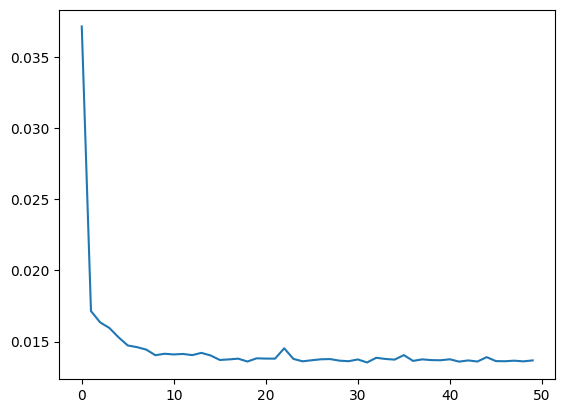

In [19]:
plt.plot(train_losses)

#### Model Eval

In [37]:
best_model = SimpleRNN(6, 32)
best_model.load_state_dict(torch.load('../training_checkpoints/lat_lon/simplernn_v1p0.pt'))

<All keys matched successfully>

Mean Power: 206.1668701171875
Mean Power Pred: 210.0843963623047


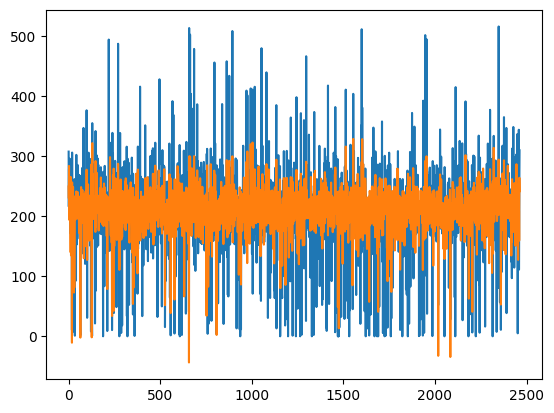

In [20]:
model.eval()
powers = []
power_preds = []
with torch.no_grad():
    for i, (x, y) in enumerate(dataloader):
        pred_power = model(x)
        pred_power = dataset.output_scaler.inverse_transform(pred_power.cpu().numpy())
        power = dataset.output_scaler.inverse_transform(y.cpu().numpy())
        powers.append(power)
        power_preds.append(pred_power)

# Debatch
powers = np.concatenate(powers)
power_preds = np.concatenate(power_preds)
print(f'Mean Power: {powers.mean()}')
print(f'Mean Power Pred: {power_preds.mean()}')


plt.plot(powers)
plt.plot(power_preds)